In [1]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os
from pyspark.sql.functions import col, isnull, count, avg, expr, when, sum as sum_,concat_ws, first, countDistinct, rank,regexp_replace, trim, isnan, to_date, coalesce, lit, round, year, month
from pyspark.sql.types import StructType, StructField,  StringType, IntegerType, FloatType, DateType
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Charger les variables d'environnement
load_dotenv("/home/jovyan/work/.env")

# Initialiser Spark avec tous les JARs nécessaires
spark = SparkSession.builder \
    .appName("LectureDonnees") \
    .config("spark.master", "spark://spark:7077") \
    .config("spark.jars", "/home/jovyan/.ivy2/jars/mongo-spark-connector_2.12-3.0.1.jar,/home/jovyan/.ivy2/jars/postgresql-42.6.0.jar,/home/jovyan/.ivy2/jars/mongo-java-driver-3.12.11.jar,/home/jovyan/.ivy2/jars/bson-3.12.11.jar") \
    .config("spark.driver.extraClassPath", "/home/jovyan/.ivy2/jars/mongo-spark-connector_2.12-3.0.1.jar:/home/jovyan/.ivy2/jars/postgresql-42.6.0.jar:/home/jovyan/.ivy2/jars/mongo-java-driver-3.12.11.jar:/home/jovyan/.ivy2/jars/bson-3.12.11.jar") \
    .config("spark.executor.extraClassPath", "/home/jovyan/.ivy2/jars/mongo-spark-connector_2.12-3.0.1.jar:/home/jovyan/.ivy2/jars/postgresql-42.6.0.jar:/home/jovyan/.ivy2/jars/mongo-java-driver-3.12.11.jar:/home/jovyan/.ivy2/jars/bson-3.12.11.jar") \
    .getOrCreate()

# Etude base "délinquance" (sql) 

In [3]:
# Récupérer les variables d'environnement
#Pour Postgres
db_user = os.getenv("POSTGRES_USER")
db_password = os.getenv("POSTGRES_PASSWORD")
db_host = "postgres_dvf"
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("POSTGRES_DB")


try:
    df_postgres = spark.read \
        .format("jdbc") \
        .option("url", f"jdbc:postgresql://{db_host}:{db_port}/{db_name}") \
        .option("dbtable", "delinquance_idf") \
        .option("user", db_user) \
        .option("password", db_password) \
        .option("driver", "org.postgresql.Driver") \
        .load()

    print("✅ Connexion PostgreSQL réussie ! Voici un aperçu des données :")
    df_postgres.limit(5).show()
    df_postgres.printSchema()
    # Calcul du pourcentage de valeurs nulles par colonne
    null_percentages = df_postgres.select(
        [count(when(isnull(c), c)).alias(c) for c in df_postgres.columns]
    ).collect()[0].asDict()

    total_rows = df_postgres.count()
    null_percentages = {k: (v / total_rows) * 100 for k, v in null_percentages.items()}

    print("\nPourcentage de valeurs nulles par colonne :")
    for col_name, percent in null_percentages.items():
        print(f"{col_name}: {percent:.2f}%")
  

except Exception as e:
    print(f"❌ Erreur PostgreSQL : {e}")

✅ Connexion PostgreSQL réussie ! Voici un aperçu des données :
+-----------+-----+--------------------+---------------+--------+---------------+-----------+---------+-------------------+---------+-------------------+----------------------+--------------------+-------------------+-----------------+-----------+----------------------+-------+
|CODGEO_2025|annee|          indicateur|unite_de_compte|  nombre|taux_pour_mille|est_diffuse|insee_pop|insee_pop_millesime|insee_log|insee_log_millesime|complement_info_nombre|complement_info_taux|#Code_commune_INSEE|Nom_de_la_commune|Code_postal|Libellé_d_acheminement|Ligne_5|
+-----------+-----+--------------------+---------------+--------+---------------+-----------+---------+-------------------+---------+-------------------+----------------------+--------------------+-------------------+-----------------+-----------+----------------------+-------+
|      75056| 2016|Violences physiqu...|        Victime| 3307.00|           NULL|       diff|  21903

Nous allons concerver uniquement les colonnes :

- CODGEO_2025
- annee
- indicateur
- unite_de_compte
- nombre
- est_diffuse
- insee_pop
- insee_log_millesime
- Nom_de_la_commune
- Code_postal

In [4]:
#Selection des colonnes et suppression des nulls
df_postgres_selection= df_postgres.select(
    "CODGEO_2025",
    "annee",
    "indicateur",
    "unite_de_compte",
    "nombre",
    "est_diffuse",
    "insee_pop",
    "insee_pop_millesime",
    "Nom_de_la_commune",
    "Code_postal"
).na.drop()

df_postgres_selection.limit(5).show()

# Ajout de la catégorie du crime:
df_postgres_selection = df_postgres_selection.withColumn(
    "catégorie",
    when(col("indicateur") == "Usage de stupéfiants", "Stupéfiants")
    .when(col("indicateur") == "Usage de stupéfiants (AFD)", "Stupéfiants")
    .when(col("indicateur") == "Trafic de stupéfiants", "Stupéfiants")
    .when(col("indicateur") == "Vols de véhicule", "Vols")
    .when(col("indicateur") == "Vols d'accessoires sur véhicules", "Vols")
    .when(col("indicateur") == "Vols dans les véhicules", "Vols")
    .when(col("indicateur") == "Vols avec armes", "Vols")
    .when(col("indicateur") == "Vols violents sans arme", "Vols")
    .when(col("indicateur") == "Vols sans violence contre des personnes", "Vols")
    .when(col("indicateur") == "Escroqueries et fraudes aux moyens de paiement", "Escroqueries")
    .when(col("indicateur") == "Violences physiques hors cadre familial", "Violences")
    .when(col("indicateur") == "Violences sexuelles", "Violences")
    .when(col("indicateur") == "Violences physiques intrafamiliales", "Violences")
    .when(col("indicateur") == "Destructions et dégradations volontaires", "Destructions")
    .when(col("indicateur") == "Cambriolages de logement", "Cambriolages")
    .otherwise("Autres")
)

# Aggrégation suivant département, annee et indicateur:

df_postgres_dept = df_postgres_selection.withColumn(
    "département",
    expr("substring(Code_postal, 1, 2)")
)
df_postgres_dept.limit(5).show()

df_postgres_dept = df_postgres_dept.withColumn(
    "group_key",
    concat_ws("|", col("annee"), col("catégorie"), col("département"))
)

# Liste des valeurs distinctes pour la colonne "indicateur"
distinct_indicateurs = df_postgres_dept.select("indicateur").distinct()
# Affichage du résultat
print("Liste des valeurs distinctes pour 'indicateur' :")
distinct_indicateurs.show(truncate=False)

df_postgres_grouped = df_postgres_dept.groupBy("group_key").agg(
    first("département").alias("département"),
    first("annee").alias("annee"),
    first("catégorie").alias("catégorie"),
    sum_("nombre").alias("nombre_total"),
    first("insee_pop").alias("insee_pop")
)

# Ajout de la colonne "taux_pour_mille"
df_postgres_grouped = df_postgres_grouped.withColumn(
    "taux_pour_mille",
    (col("nombre_total") / col("insee_pop")) * 1000
)

df_postgres_grouped.limit(5).show()


+-----------+-----+--------------------+---------------+------+-----------+---------+-------------------+-----------------+-----------+
|CODGEO_2025|annee|          indicateur|unite_de_compte|nombre|est_diffuse|insee_pop|insee_pop_millesime|Nom_de_la_commune|Code_postal|
+-----------+-----+--------------------+---------------+------+-----------+---------+-------------------+-----------------+-----------+
|      75101| 2016|Violences physiqu...|        Victime| 35.00|       diff|    16252|               2016|         PARIS 01|      75001|
|      75101| 2016|Violences physiqu...|        Victime|306.00|       diff|    16252|               2016|         PARIS 01|      75001|
|      75101| 2016| Violences sexuelles|        Victime| 82.00|       diff|    16252|               2016|         PARIS 01|      75001|
|      75101| 2016|     Vols avec armes|     Infraction| 28.00|       diff|    16252|               2016|         PARIS 01|      75001|
|      75101| 2016|Vols violents san...|     Inf

Représentation graphique

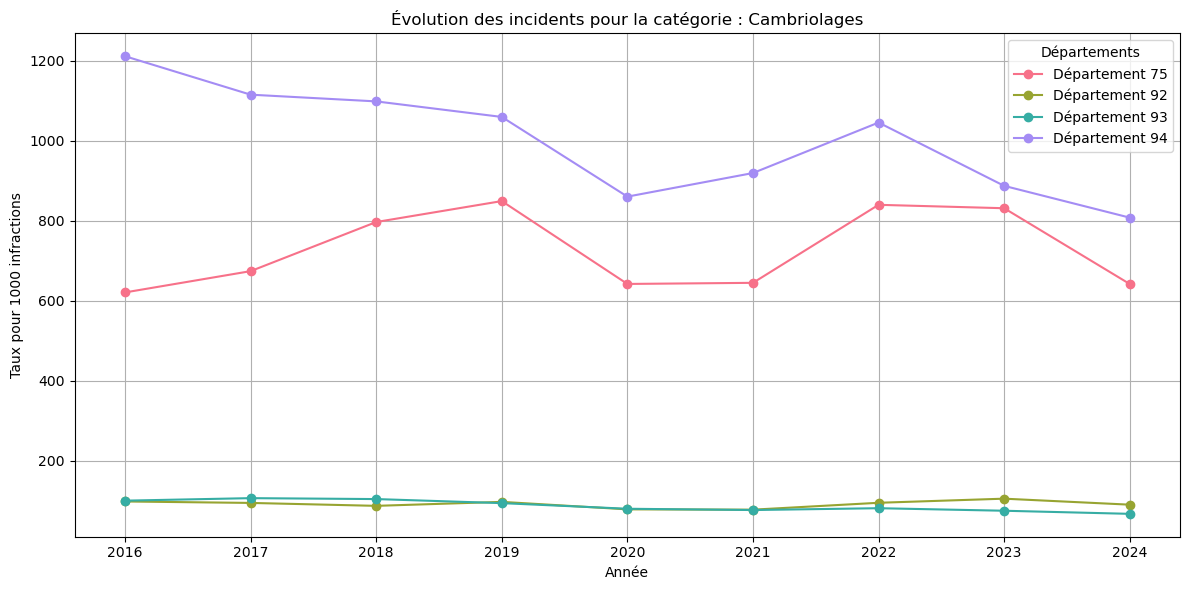

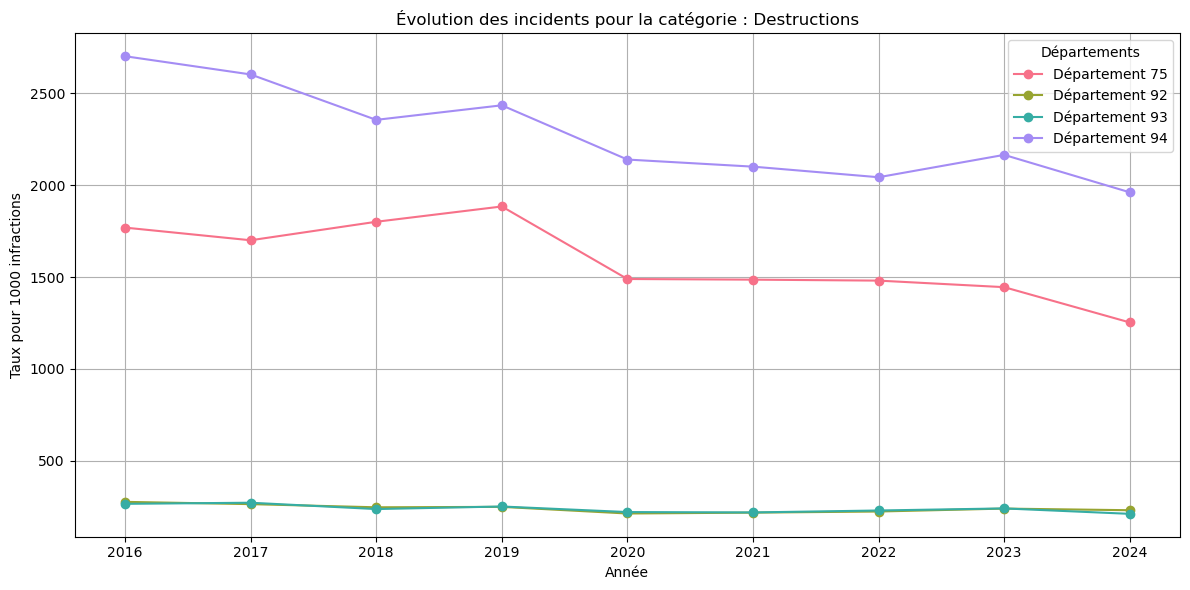

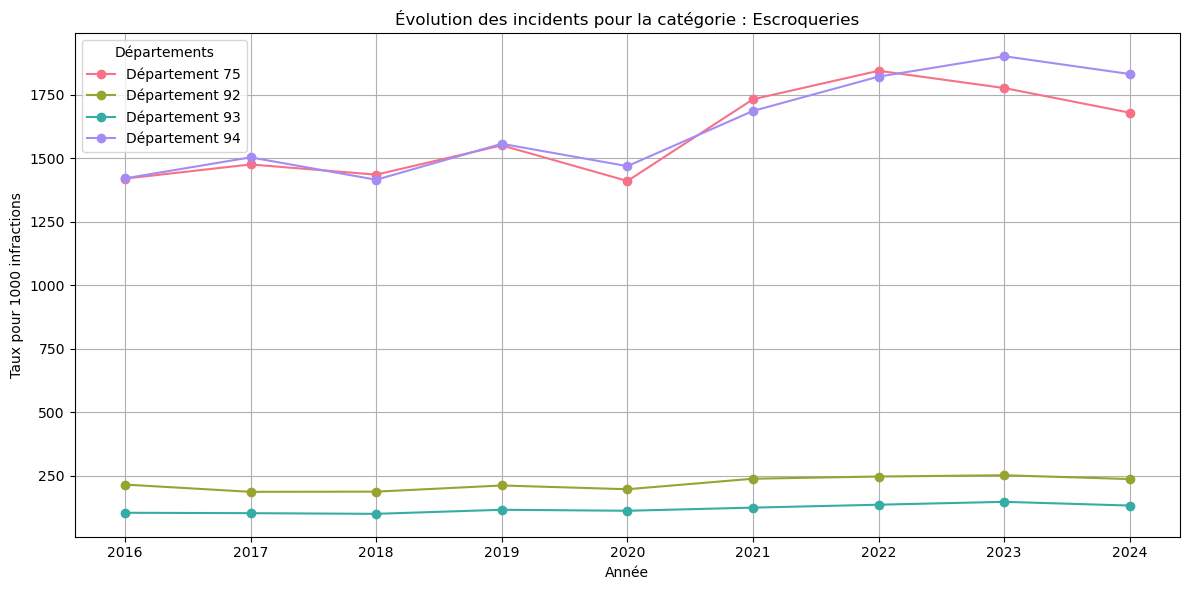

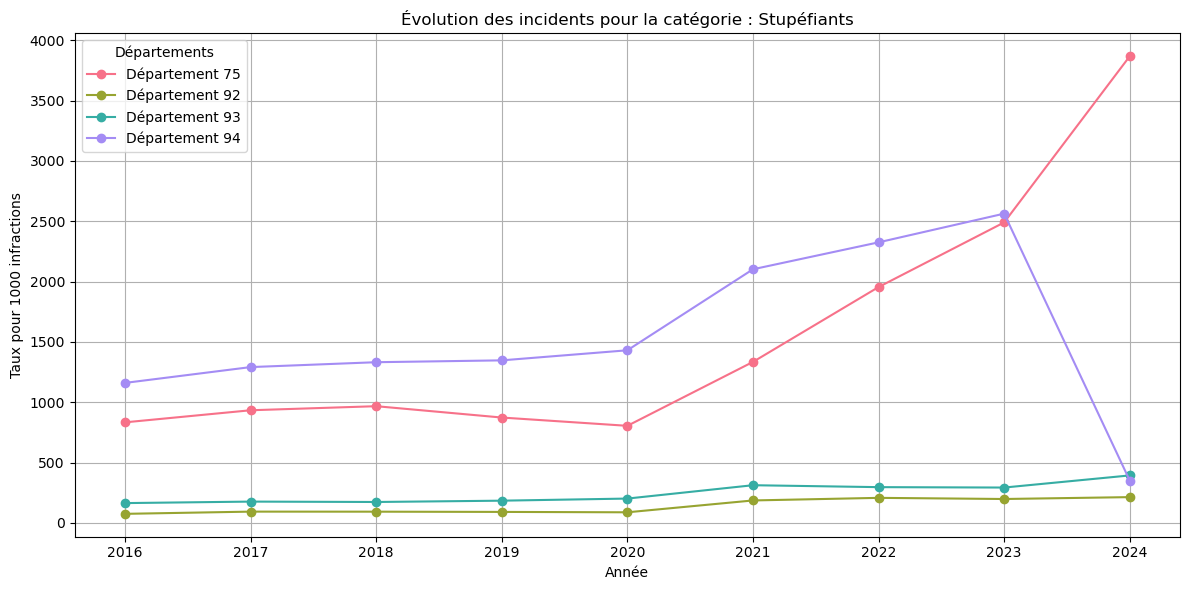

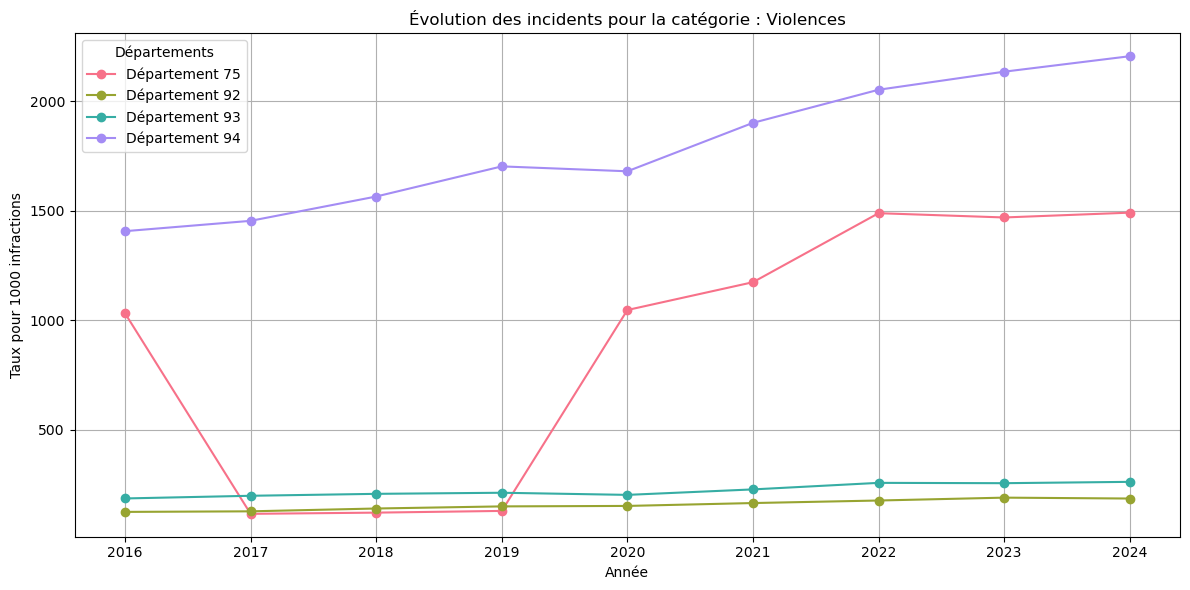

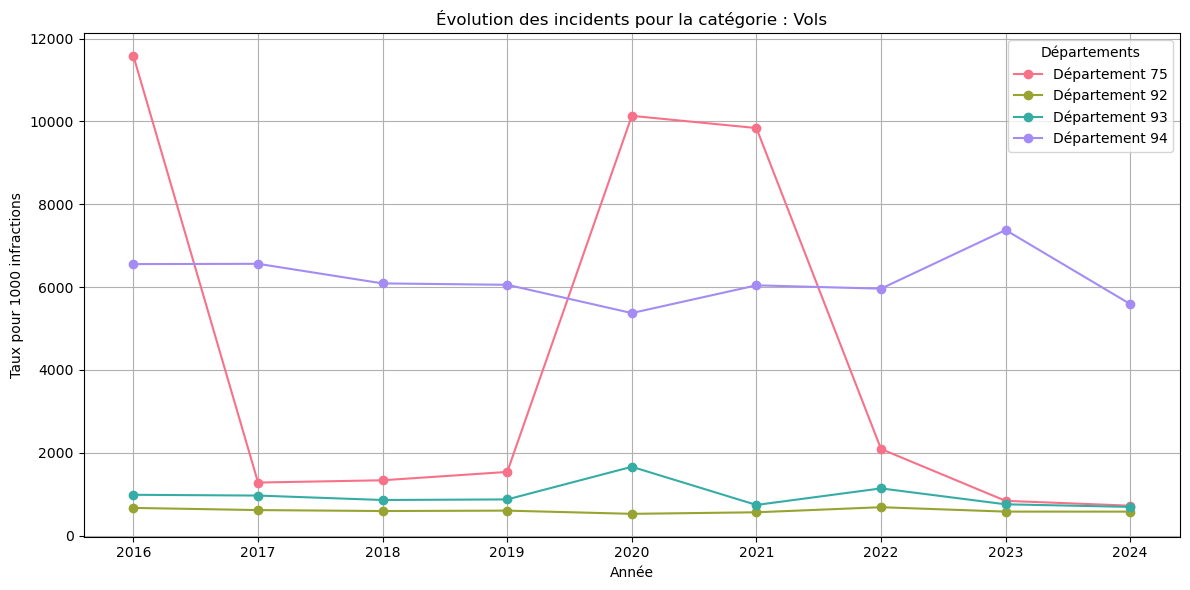

In [5]:
# Conversion en Pandas pour la visualisation
df_postgres_grouped_pandas = df_postgres_grouped.toPandas()

# Liste des catégories à tracer
categories = df_postgres_grouped_pandas["catégorie"].unique()

# Boucle sur chaque catégorie
for category in categories:
    # Filtrer les données pour la catégorie actuelle
    df_category = df_postgres_grouped_pandas[df_postgres_grouped_pandas["catégorie"] == category]

    # Initialiser la figure pour cette catégorie
    plt.figure(figsize=(12, 6))

    # Palette de couleurs pour les départements
    palette = sns.color_palette("husl", n_colors=len(df_category["département"].unique()))

    # Tracer une courbe par département
    for i, dept in enumerate(df_category["département"].unique()):
        df_dept = df_category[df_category["département"] == dept]
        plt.plot(
            df_dept["annee"],
            df_dept["taux_pour_mille"],
            label=f"Département {dept}",
            color=palette[i],
            linestyle="-",
            marker="o",
        )

    # Ajouter des labels et une légende
    plt.xlabel("Année")
    plt.ylabel("Taux pour 1000 infractions")
    plt.title(f"Évolution des incidents pour la catégorie : {category}")
    plt.legend(title="Départements")
    plt.grid(True)

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

Etude d'un département avec un taux d'incidents "fort": 75

Etude d'un département avec un taux d'incident "faible": 92

In [6]:
# Filtrer pour les départements 75 et 92 (sur le DataFrame PySpark)
df_filtered = df_postgres_dept.filter(
    (col("département") == "75") | (col("département") == "92")
)

# Compter le nombre de codes postaux distincts par département
df_code_postal_count = df_filtered.groupBy("département").agg(
    countDistinct("Code_postal").alias("nombre_codes_postaux_distincts")
)

# Afficher le résultat
df_code_postal_count.show()

+-----------+------------------------------+
|département|nombre_codes_postaux_distincts|
+-----------+------------------------------+
|         75|                            21|
|         92|                            37|
+-----------+------------------------------+



In [7]:
# Aggrégation par ville, catégorie et département
df_agg_villes = df_filtered.groupBy(
    "Code_postal",
    "Nom_de_la_commune",
    "catégorie",
    "département",
    "insee_pop"
).agg(
    sum_("nombre").alias("total_incidents")
)

# Ajout de la colonne "taux_pour_mille"
df_agg_villes = df_agg_villes.withColumn(
    "taux_pour_mille",
    (col("total_incidents") / col("insee_pop")) * 1000
)


# Afficher le résultat
df_agg_villes.limit(10).show(truncate=False)

+-----------+-----------------+------------+-----------+---------+---------------+---------------+
|Code_postal|Nom_de_la_commune|catégorie   |département|insee_pop|total_incidents|taux_pour_mille|
+-----------+-----------------+------------+-----------+---------+---------------+---------------+
|92200      |NEUILLY SUR SEINE|Escroqueries|92         |60580    |974.00         |16.0779135028  |
|75017      |PARIS 17         |Violences   |75         |167288   |998.00         |5.9657596480   |
|92330      |SCEAUX           |Vols        |92         |19344    |427.00         |22.0740281224  |
|75015      |PARIS 15         |Vols        |75         |232144   |9948.00        |42.8527121097  |
|75014      |PARIS 14         |Destructions|75         |133967   |995.00         |7.4272022214   |
|75019      |PARIS 19         |Vols        |75         |183211   |11000.00       |60.0400630966  |
|75004      |PARIS 04         |Stupéfiants |75         |28324    |452.00         |15.9581979946  |
|75014    

In [8]:
# Créer une fenêtre pour classer les villes par catégorie et département
window_spec = Window.partitionBy("catégorie", "département").orderBy(col("taux_pour_mille").desc())

# Ajouter un rang à chaque ville
df_ranked = df_agg_villes.withColumn("rank", rank().over(window_spec))

# Filtrer pour garder uniquement le top 3
df_top5 = df_ranked.filter(col("rank") <= 3).drop("rank")



In [9]:
# Afficher le top 5 des villes par catégorie et département
# Pour 75:
df_75 = df_top5.filter(col("département") == "75")
print("Top 3 des villes pour chaque catégorie pour le département 75:")
df_75.orderBy("catégorie", "département", col("taux_pour_mille").desc()).show(truncate=False)

Top 3 des villes pour chaque catégorie pour le département 75:
+-----------+-----------------+------------+-----------+---------+---------------+---------------+
|Code_postal|Nom_de_la_commune|catégorie   |département|insee_pop|total_incidents|taux_pour_mille|
+-----------+-----------------+------------+-----------+---------+---------------+---------------+
|75001      |PARIS 01         |Cambriolages|75         |15475    |571.00         |36.8982229402  |
|75002      |PARIS 02         |Cambriolages|75         |20433    |749.00         |36.6563891744  |
|75003      |PARIS 03         |Cambriolages|75         |32772    |1001.00        |30.5443671427  |
|75001      |PARIS 01         |Destructions|75         |15475    |1106.00        |71.4701130856  |
|75008      |PARIS 08         |Destructions|75         |35418    |2190.00        |61.8329662883  |
|75002      |PARIS 02         |Destructions|75         |20433    |1109.00        |54.2749473890  |
|75008      |PARIS 08         |Escroqueries|75

In [10]:
# Afficher le top 5 des villes par catégorie et département
# Pour 92:
df_92 = df_top5.filter(col("département") == "92")
print("Top 3 des villes pour chaque catégorie pour le département 92:")
df_92.orderBy("catégorie", "département", col("taux_pour_mille").desc()).show(truncate=False)

Top 3 des villes pour chaque catégorie pour le département 92:
+-----------+---------------------+------------+-----------+---------+---------------+---------------+
|Code_postal|Nom_de_la_commune    |catégorie   |département|insee_pop|total_incidents|taux_pour_mille|
+-----------+---------------------+------------+-----------+---------+---------------+---------------+
|92500      |RUEIL MALMAISON      |Cambriolages|92         |80842    |2522.00        |31.1966552040  |
|92420      |VAUCRESSON           |Cambriolages|92         |8506     |238.00         |27.9802492358  |
|92410      |VILLE D AVRAY        |Cambriolages|92         |10871    |239.00         |21.9850979671  |
|92500      |RUEIL MALMAISON      |Destructions|92         |80842    |3564.00        |44.0859949036  |
|92140      |CLAMART              |Destructions|92         |56882    |2500.00        |43.9506346472  |
|92000      |NANTERRE             |Destructions|92         |98119    |3345.00        |34.0912565354  |
|92500    

3 Villes se démarque:

- Rueil: pour les catégories Cambriolages, Escroqueries, Destructions et Violences
- Puteaux: pour les catégorie Stupéfiants et Vols.

Pour la suite de l'étude je vous propose de se focaliser sur les villes ou arrondissement suivants:

- Paris 1er
- Paris 8ème
- Rueil
- Puteaux

# Etude de la base "valeurs foncières" (NoSQL)

In [11]:
# Récupérer les variables d'environnement pour MongoDB
mongo_user = os.getenv("MONGO_INITDB_ROOT_USERNAME")
mongo_password = os.getenv("MONGO_INITDB_ROOT_PASSWORD")
mongo_host = os.getenv("MONGO_HOST", "mongodb_delinquance")
mongo_port = os.getenv("MONGO_PORT", "27017")
mongo_db = os.getenv("MONGO_DB")
mongo_collection = "idf_2023_2024"

# Construire l'URI MongoDB
uri = f"mongodb://{mongo_user}:{mongo_password}@{mongo_host}:{mongo_port}/{mongo_db}.{mongo_collection}?authSource=admin"

try:
    # 1. Lire UN SEUL document pour obtenir la structure
    sample_doc = spark.read.format("mongo").option("uri", uri).load().first().asDict()
    print(sample_doc)
    # 2. Créer un schéma où toutes les colonnes sont de type String
    schema = StructType([StructField(name, StringType(), True) for name in sample_doc.keys()])
    df_mongo = spark.read.format("mongo").option("uri", uri).schema(schema).load()
    print("✅ Connexion MongoDB réussie ! Voici un aperçu des données :")
    df_mongo.printSchema()
    df_mongo.limit(5).show()
    # 5. Calcul du pourcentage de valeurs nulles, vides, "null" ou NaN par colonne
    total_rows = df_mongo.count()
    null_empty_counts = df_mongo.select(
        [
            count(
                when(
                    isnull(c) | (trim(col(c)) == "") | (col(c) == "null") | isnan(c),
                    c
                )
            ).alias(c)
            for c in df_mongo.columns
        ]
    ).collect()[0].asDict()
    
    # 6. Calcul du pourcentage
    null_empty_percent = {k: (v / total_rows) * 100 for k, v in null_empty_counts.items()}
    
    print("\nPourcentage de valeurs nulles, vides, 'null' ou NaN par colonne :")
    for col_name, percent in null_empty_percent.items():
        print(f"{col_name}: {percent:.2f}%")


except Exception as e:
    print(f"❌ Erreur MongoDB : {e}")

{'1 Articles CGI': nan, '1er lot': '12.0', '2 Articles CGI': nan, '2eme lot': 'NaN', '3 Articles CGI': nan, '3eme lot': nan, '4 Articles CGI': nan, '4eme lot': nan, '5 Articles CGI': nan, '5eme lot': nan, 'B/T/Q': 'B', 'Code commune': 44, 'Code departement': 92, 'Code postal': 92300.0, 'Code type local': 2.0, 'Code voie': '3125', 'Commune': 'LEVALLOIS-PERRET', 'Date mutation': '06/01/2023', 'Identifiant de document': nan, 'Identifiant local': nan, 'Nature culture': 'NaN', 'Nature culture speciale': 'NaN', 'Nature mutation': 'Vente', 'No Volume': nan, 'No disposition': 1, 'No plan': 134, 'No voie': 11.0, 'Nombre de lots': 1, 'Nombre pieces principales': 5.0, 'Prefixe de section': nan, 'Reference document': nan, 'Section': 'R', 'Surface Carrez du 1er lot': '40,72', 'Surface Carrez du 2eme lot': 'NaN', 'Surface Carrez du 3eme lot': 'NaN', 'Surface Carrez du 4eme lot': 'NaN', 'Surface Carrez du 5eme lot': nan, 'Surface reelle bati': 34.0, 'Surface terrain': nan, 'Type de voie': 'RUE', 'Typ

In [12]:
# Liste des colonnes à conserver
colonnes_a_conserver = [
    "Code postal",
    "Commune",
    "Date mutation",
    "Nature mutation",
    "Nombre pieces principales",
    "Surface Carrez du 1er lot",
    "Surface Carrez du 2eme lot",
    "Surface Carrez du 3eme lot",
    "Surface Carrez du 4eme lot",
    "Surface Carrez du 5eme lot",
    "Surface reelle bati",
    "Surface terrain",
    "Type local",
    "Valeur fonciere"
]

# Filtrer le DataFrame pour ne garder que ces colonnes
df_mongo_filtre = df_mongo.select(*colonnes_a_conserver)

# Afficher le schéma du DataFrame filtré
df_mongo_filtre.printSchema()

# Afficher un aperçu des données
df_mongo_filtre.limit(5).show(truncate=False)

# 2. Conversion des colonnes selon les types demandés
df_mongo_converti = (
    df_mongo_filtre
    .withColumn("Code postal", col("Code postal").cast(IntegerType()))
    .withColumn("Commune", col("Commune").cast("string"))
    .withColumn("Date mutation", to_date(col("Date mutation"), "dd/MM/yyyy"))  # Ajuste le format si nécessaire
    .withColumn("Nature mutation", col("Nature mutation").cast("string"))
    .withColumn("Nombre pieces principales", col("Nombre pieces principales").cast(IntegerType()))
    .withColumn("Surface Carrez du 1er lot", regexp_replace(col("Surface Carrez du 1er lot"), ",", ".").cast(FloatType()))
    .withColumn("Surface Carrez du 2eme lot", regexp_replace(col("Surface Carrez du 2eme lot"), ",", ".").cast(FloatType()))
    .withColumn("Surface Carrez du 3eme lot", regexp_replace(col("Surface Carrez du 3eme lot"), ",", ".").cast(FloatType()))
    .withColumn("Surface Carrez du 4eme lot", regexp_replace(col("Surface Carrez du 4eme lot"), ",", ".").cast(FloatType()))
    .withColumn("Surface Carrez du 5eme lot", regexp_replace(col("Surface Carrez du 5eme lot"), ",", ".").cast(FloatType()))
    .withColumn("Surface reelle bati", regexp_replace(col("Surface reelle bati"), ",", ".").cast(FloatType()))
    .withColumn("Surface terrain", regexp_replace(col("Surface terrain"), ",", ".").cast(FloatType()))
    .withColumn("Type local", col("Type local").cast("string"))
    .withColumn("Valeur fonciere", regexp_replace(col("Valeur fonciere"), ",", ".").cast(FloatType()))
)

# 3. Afficher le schéma pour vérifier les types
df_mongo_converti.printSchema()

# 4. Afficher un aperçu des données
df_mongo_converti.limit(5).show(truncate=False)

root
 |-- Code postal: string (nullable = true)
 |-- Commune: string (nullable = true)
 |-- Date mutation: string (nullable = true)
 |-- Nature mutation: string (nullable = true)
 |-- Nombre pieces principales: string (nullable = true)
 |-- Surface Carrez du 1er lot: string (nullable = true)
 |-- Surface Carrez du 2eme lot: string (nullable = true)
 |-- Surface Carrez du 3eme lot: string (nullable = true)
 |-- Surface Carrez du 4eme lot: string (nullable = true)
 |-- Surface Carrez du 5eme lot: string (nullable = true)
 |-- Surface reelle bati: string (nullable = true)
 |-- Surface terrain: string (nullable = true)
 |-- Type local: string (nullable = true)
 |-- Valeur fonciere: string (nullable = true)

+-----------+------------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+


In [13]:
# Valeurs distinctes pour "Nature mutation"
print("Valeurs distinctes pour 'Nature mutation' :")
df_mongo_converti.select("Nature mutation").distinct().show(truncate=False)

# Valeurs distinctes pour "Type local"
print("\nValeurs distinctes pour 'Type local' :")
df_mongo_converti.select("Type local").distinct().show(truncate=False)

Valeurs distinctes pour 'Nature mutation' :
+------------------------------------+
|Nature mutation                     |
+------------------------------------+
|Vente en l'Ã©tat futur d'achÃ¨vement|
|Echange                             |
|Vente                               |
|Vente terrain Ã  bÃ¢tir             |
|Adjudication                        |
|Expropriation                       |
+------------------------------------+


Valeurs distinctes pour 'Type local' :
+-----------------------------------------+
|Type local                               |
+-----------------------------------------+
|DÃ©pendance                              |
|Appartement                              |
|Local industriel. commercial ou assimilÃ©|
|Maison                                   |
|NaN                                      |
+-----------------------------------------+



Je vais concerver uniquement :

Vente pour la variable Nature de mutation

Appartement et Maison pour la variable Type local

In [14]:
# Liste des codes postaux à conserver
codes_postaux_a_filtrer = ["75001", "75008", "92500", "92800"]

# Filtrer le DataFrame
df_mongo_filtre_cp = df_mongo_converti.filter(
    (col("Code postal").isin(codes_postaux_a_filtrer)) &
    (col("Nature mutation") == "Vente") &
    (col("Type local").isin(["Appartement", "Maison"])) 
)


# Afficher le nombre de lignes après filtrage
print(f"Nombre de lignes après filtrage : {df_mongo_filtre_cp.count()}")

# Afficher un aperçu des données filtrées
df_mongo_filtre_cp.limit(5).show(truncate=False)

Nombre de lignes après filtrage : 5970
+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+
|Code postal|Commune        |Date mutation|Nature mutation|Nombre pieces principales|Surface Carrez du 1er lot|Surface Carrez du 2eme lot|Surface Carrez du 3eme lot|Surface Carrez du 4eme lot|Surface Carrez du 5eme lot|Surface reelle bati|Surface terrain|Type local |Valeur fonciere|
+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+
|92800      |PUTEAUX        |2023-01-06   |Vente          |2                        |46.82                   

In [15]:
#1. Remplacer les NaN par 0 dans chaque colonne de surface Carrez
for lot in ["1er", "2eme", "3eme", "4eme", "5eme"]:
    df_mongo_filtre_cp = df_mongo_filtre_cp.withColumn(
        f"Surface Carrez du {lot} lot",
        when(
            isnan(col(f"Surface Carrez du {lot} lot")) | col(f"Surface Carrez du {lot} lot").isNull(),
            0.0
        ).otherwise(col(f"Surface Carrez du {lot} lot"))
    )

# 2. Créer la nouvelle variable Tot_Surface_Carrez (somme des 5 lots)
df_mongo_filtre_cp = df_mongo_filtre_cp.withColumn(
    "Tot_Surface_Carrez",
    col("Surface Carrez du 1er lot") +
    col("Surface Carrez du 2eme lot") +
    col("Surface Carrez du 3eme lot") +
    col("Surface Carrez du 4eme lot") +
    col("Surface Carrez du 5eme lot")
)

# 3. Afficher le résultat pour vérifier
df_mongo_filtre_cp.limit(5).show(truncate=False)

+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+------------------+
|Code postal|Commune        |Date mutation|Nature mutation|Nombre pieces principales|Surface Carrez du 1er lot|Surface Carrez du 2eme lot|Surface Carrez du 3eme lot|Surface Carrez du 4eme lot|Surface Carrez du 5eme lot|Surface reelle bati|Surface terrain|Type local |Valeur fonciere|Tot_Surface_Carrez|
+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+------------------+
|92800      |PUTEAUX        |2023-01-06   |Vente          |2                        |46.819

In [16]:
#Calcul du prix au m²
df_mongo_filtre_cp = df_mongo_filtre_cp.withColumn(
    "Prix_m2",
    when(
        col("Tot_Surface_Carrez") > 0,  # Vérifie que la surface n'est pas nulle ou négative
        col("Valeur fonciere") / col("Tot_Surface_Carrez")
    ).otherwise(None)  # Met None si la surface est 0 (évite la division par zéro)
)

# Arrondir la colonne Prix_m2 à 2 décimales
df_mongo_filtre_cp = df_mongo_filtre_cp.withColumn(
    "Prix_m2",
    round(col("Prix_m2"), 2)  # Arrondit à 2 décimales
)

# Extraire l'année et le mois à partir de "Date mutation"
df_mongo_filtre_cp = df_mongo_filtre_cp.withColumn(
    "Annee", year(col("Date mutation"))
).withColumn(
    "Mois", month(col("Date mutation"))
)

#Afficher le résultat pour vérifier
df_mongo_filtre_cp.limit(5).show(truncate=False)

+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+------------------+-------+-----+----+
|Code postal|Commune        |Date mutation|Nature mutation|Nombre pieces principales|Surface Carrez du 1er lot|Surface Carrez du 2eme lot|Surface Carrez du 3eme lot|Surface Carrez du 4eme lot|Surface Carrez du 5eme lot|Surface reelle bati|Surface terrain|Type local |Valeur fonciere|Tot_Surface_Carrez|Prix_m2|Annee|Mois|
+-----------+---------------+-------------+---------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-------------------+---------------+-----------+---------------+------------------+-------+-----+----+
|92800      |PUTEAUX        |2023-

In [17]:
# Agrégation par code postal, type local, année et mois
df_agg = df_mongo_filtre_cp.groupBy(
    "Code postal",
    "Type local",
    "Annee",
    "Mois"
).agg(
    avg("Prix_m2").alias("Prix_m2_moyen"),  # Moyenne du prix au m²
    count("*").alias("Nombre_de_biens")    # Nombre de biens dans chaque groupe
).orderBy(
    "Code postal",
    "Type local",
    "Annee",
    "Mois"
)

# Afficher le résultat
df_agg.show(truncate=False)

+-----------+-----------+-----+----+------------------+---------------+
|Code postal|Type local |Annee|Mois|Prix_m2_moyen     |Nombre_de_biens|
+-----------+-----------+-----+----+------------------+---------------+
|75001      |Appartement|2023 |1   |13643.065714285718|36             |
|75001      |Appartement|2023 |2   |13633.673571428573|35             |
|75001      |Appartement|2023 |3   |13482.185000000001|48             |
|75001      |Appartement|2023 |4   |16049.789545454549|35             |
|75001      |Appartement|2023 |5   |13889.758666666667|22             |
|75001      |Appartement|2023 |6   |19761.456         |55             |
|75001      |Appartement|2023 |7   |15027.297222222222|54             |
|75001      |Appartement|2023 |8   |20995.64846153846 |17             |
|75001      |Appartement|2023 |9   |13980.020833333334|31             |
|75001      |Appartement|2023 |10  |16412.187333333335|29             |
|75001      |Appartement|2023 |11  |12448.242222222223|27       

<Figure size 1400x800 with 0 Axes>

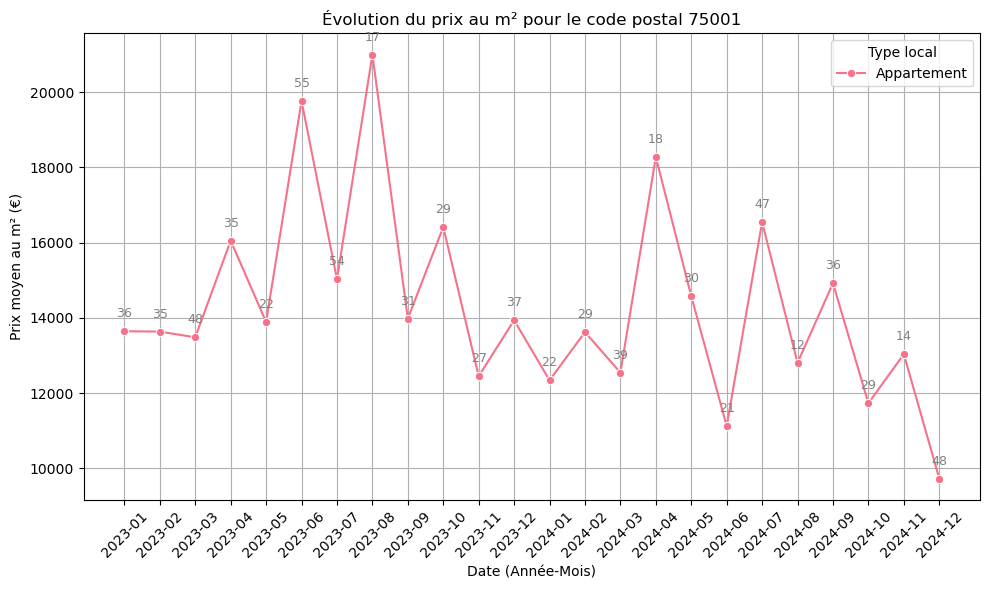

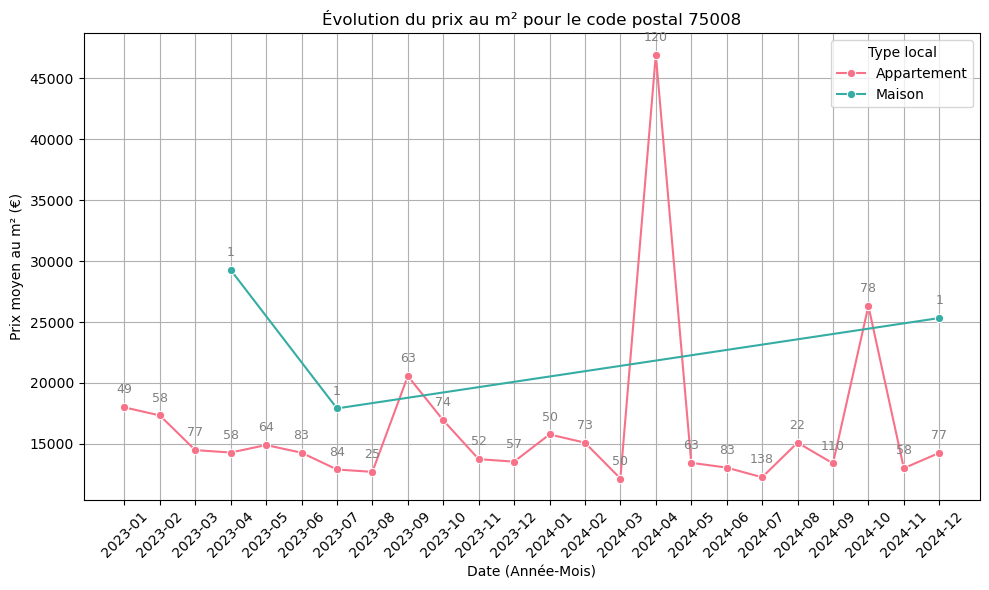

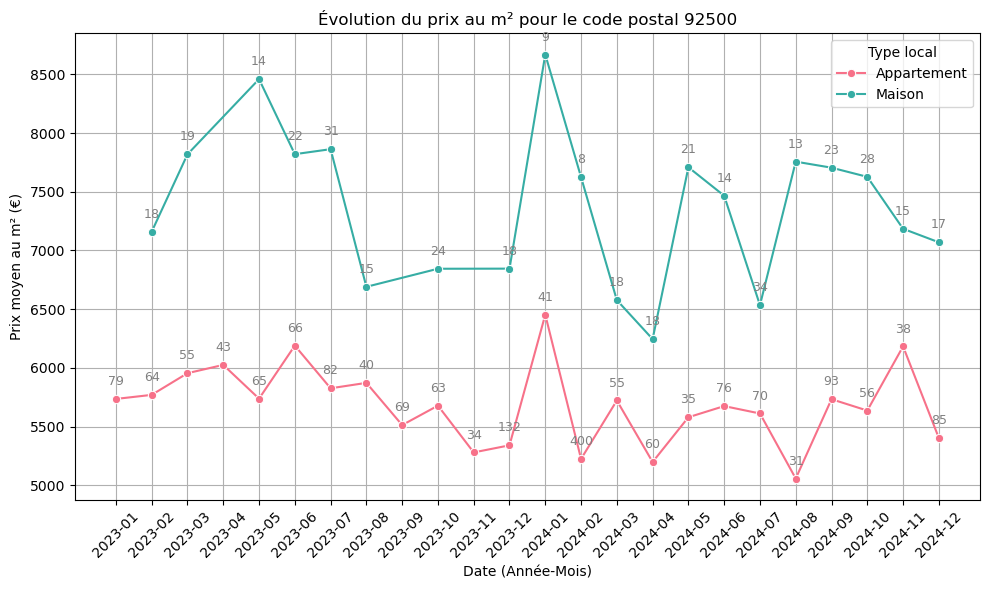

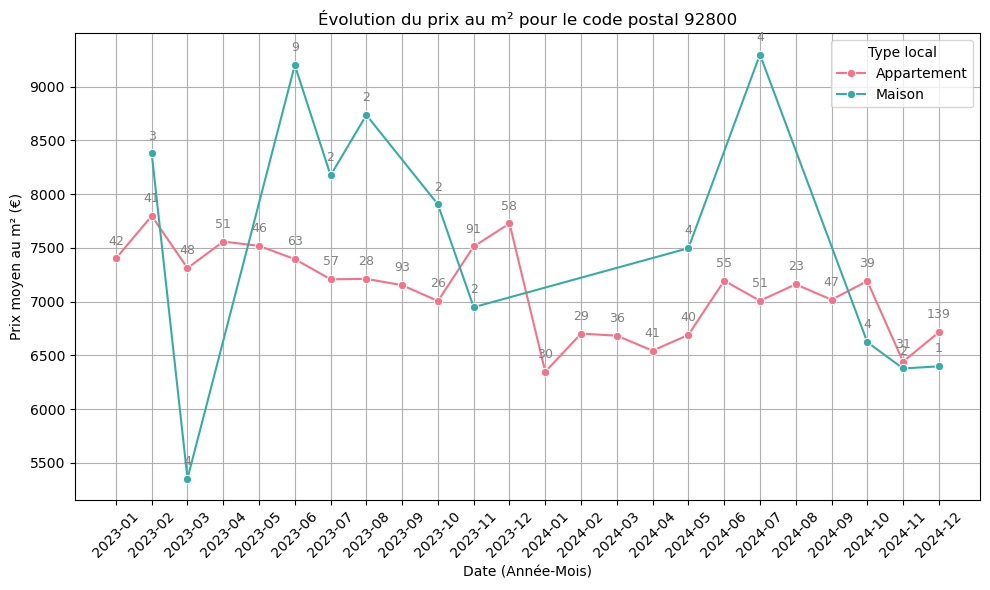

In [18]:
# Conversion en Pandas pour la visualisation
df_agg_pandas = df_agg.toPandas()

# Définir la taille de la figure
plt.figure(figsize=(14, 8))

# Créer une colonne "Date" pour l'axe des abscisses
df_agg_pandas["Date"] = df_agg_pandas["Annee"].astype(str) + "-" + df_agg_pandas["Mois"].astype(str).str.zfill(2)

# Liste des codes postaux uniques
codes_postaux = df_agg_pandas["Code postal"].unique()

# Boucle pour créer un graphique par code postal
for code_postal in codes_postaux:
    # Filtrer les données pour le code postal actuel
    df_code_postal = df_agg_pandas[df_agg_pandas["Code postal"] == code_postal]

    # Créer une figure
    plt.figure(figsize=(10, 6))

    # Tracer les courbes pour chaque type de local
    ax=sns.lineplot(
        data=df_code_postal,
        x="Date",
        y="Prix_m2_moyen",
        hue="Type local",
        marker="o",
        palette="husl"
    )

    # Ajouter des annotations pour le nombre de biens
    for type_local in df_code_postal["Type local"].unique():
        df_type_local = df_code_postal[df_code_postal["Type local"] == type_local]
        for _, row in df_type_local.iterrows():
            ax.annotate(
                row["Nombre_de_biens"],
                (row["Date"], row["Prix_m2_moyen"]),
                textcoords="offset points",
                xytext=(0, 10),  # Décalage vertical
                ha="center",     # Alignement horizontal
                fontsize=9,
                color="gray"
            )

    # Ajouter des labels et un titre
    plt.title(f"Évolution du prix au m² pour le code postal {code_postal}")
    plt.xlabel("Date (Année-Mois)")
    plt.ylabel("Prix moyen au m² (€)")
    plt.xticks(rotation=45)
    plt.grid(True)

    # Afficher la légende
    plt.legend(title="Type local")

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

In [19]:
spark.stop()